In [ ]:
!pip install --upgrade \
  torch==2.6.0+cu124 torchvision==0.15.2+cu124 torchaudio==2.6.0+cu124 \
  --extra-index-url https://download.pytorch.org/whl/cu124

!pip install --upgrade \
  discopy>=1.1.0 \
  lambeq \
  pennylane pennylane-lightning \
  networkx


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.2+cu124 (from versions: 0.1.6, 0.2.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.0+cu124, 0.19.1, 0.19.1+cu124, 0.20.0, 0.20.0+cu124, 0.20.1, 0.20.1+cu124, 0.21.0, 0.21.0+cu124, 0.22.0, 0.22.1)
ERROR: No matching distribution found for torchvision==0.15.2+cu124



=== LSTM clásico ===
Epoch 0, Loss: 25.8864
Epoch 10, Loss: 10.4447
Epoch 20, Loss: 4.1279
Epoch 30, Loss: 1.2772
Epoch 40, Loss: 0.6153
Epoch 50, Loss: 0.3774
Epoch 60, Loss: 0.2605
Epoch 70, Loss: 0.1929
Epoch 80, Loss: 0.1495
Epoch 90, Loss: 0.1198

Generaciones de ejemplo:
Input: nlp procesa el -> Predicción: texto | Real: texto
Input: el modelo procesa -> Predicción: información | Real: información
Input: computación cuántica procesa -> Predicción: información | Real: información
Input: la computación nlp -> Predicción: modelo | Real: modelo
Input: la computación cuántica -> Predicción: procesa | Real: procesa
Input: la información texto -> Predicción: procesa | Real: procesa
Input: la información entrena -> Predicción: nlp | Real: nlp
Input: el modelo entrena -> Predicción: nlp | Real: nlp
Input: computación entrena nlp -> Predicción: modelo | Real: modelo
Input: el texto entrena -> Predicción: información | Real: información

=== QLSTM híbrido ===
Epoch 0, Loss: 27.2266
Epoch 1

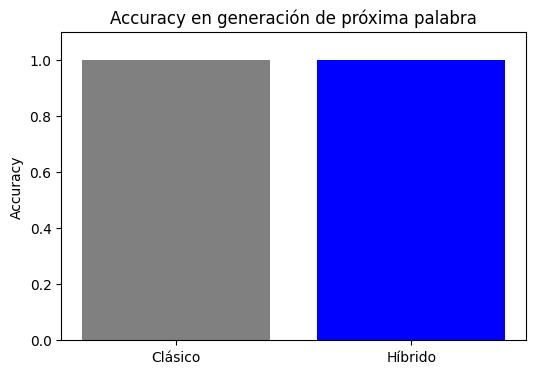

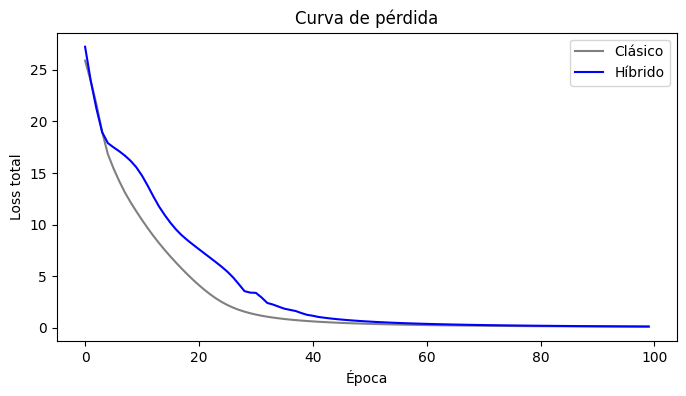

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import draw_mpl

vocabulario = ['la', 'computación', 'cuántica', 'procesa', 'información',
               'nlp', 'texto', 'modelo', 'entrena', 'el', 'clásica']
corpus = [
    ['la', 'computación', 'cuántica', 'procesa', 'información'],
    ['el', 'modelo', 'entrena', 'nlp'],
    ['nlp', 'procesa', 'el', 'texto'],
    ['la', 'información', 'entrena', 'nlp'],
    ['el', 'texto', 'procesa', 'modelo'],
    ['la', 'computación', 'nlp', 'modelo'],
    ['el', 'modelo', 'procesa', 'información'],
    ['la', 'información', 'texto', 'procesa'],
    ['computación', 'entrena', 'nlp', 'modelo'],
    ['el', 'texto', 'entrena', 'información']
]
vocab_size = len(vocabulario)
word2idx = {w: i for i, w in enumerate(vocabulario)}
idx2word = {i: w for i, w in enumerate(vocabulario)}

def generar_datos(corpus, tam_contexto=3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            entrada = frase[i:i+tam_contexto]
            salida = frase[i+tam_contexto]
            ejemplos.append((entrada, salida))
    return ejemplos

train_examples = generar_datos(corpus, tam_contexto=3)
test_examples = random.sample(train_examples, k=10)

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0)
        out, _ = self.lstm(input_seq)
        final_hidden = out[0, -1]
        return self.decoder(final_hidden)

n_qubits = 3
dev_hybrid = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev_hybrid, interface='torch')
def qlstm_circuit(inputs, weights):
    for i in range(n_qubits):
        qml.RY(inputs[i], wires=i)
        qml.Rot(*weights[i], wires=i)
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 0])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits):
        super().__init__()
        weight_shapes = {"weights": (n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(qlstm_circuit, weight_shapes)
        self.fc = nn.Linear(input_size + hidden_size, n_qubits)
        self.out = nn.Linear(n_qubits, hidden_size)
    def forward(self, x, h):
        combined = torch.cat([x, h], dim=-1)
        q_in = self.fc(combined)
        q_out = self.qlayer(q_in)
        return torch.tanh(self.out(q_out))

class QLSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = QLSTMCell(input_size, hidden_size, n_qubits)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        h = torch.zeros(self.hidden_size)
        for t in range(input_seq.shape[0]):
            h = self.cell(input_seq[t], h)
        return self.decoder(h)

def entrenar_y_evaluar(model, train_data, test_data, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for frase, label in train_data:
            x = phrase_to_tensor(frase)
            y = label_to_tensor(label)
            pred = model(x)
            loss = criterion(pred.unsqueeze(0), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

    print("\nGeneraciones de ejemplo:")
    correct = 0
    for frase, label in test_data:
        x = phrase_to_tensor(frase)
        with torch.no_grad():
            logits = model(x)
            pred_idx = torch.argmax(logits).item()
            pred = idx2word[pred_idx]
            print(f"Input: {' '.join(frase)} -> Predicción: {pred} | Real: {label}")
            if pred == label:
                correct += 1
    acc = correct / len(test_data)
    return losses, acc

results = {}

print("\n=== LSTM clásico ===")
lstm = LSTM_Generator(input_size=vocab_size, hidden_size=8, vocab_size=vocab_size)
losses_lstm, acc_lstm = entrenar_y_evaluar(lstm, train_examples, test_examples, epochs=100)
results['Clásico'] = (losses_lstm, acc_lstm)

print("\n=== QLSTM híbrido ===")
qlstm = QLSTM_Generator(input_size=vocab_size, hidden_size=8, n_qubits=3, vocab_size=vocab_size)
losses_qlstm, acc_qlstm = entrenar_y_evaluar(qlstm, train_examples, test_examples, epochs=100)
results['Híbrido'] = (losses_qlstm, acc_qlstm)

plt.figure(figsize=(6, 4))
for modelo, (_, acc) in results.items():
    plt.bar(modelo, acc, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.ylim(0, 1.1)
plt.title("Accuracy en generación de próxima palabra")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 4))
for modelo, (losses, _) in results.items():
    plt.plot(losses, label=modelo, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.xlabel("Época")
plt.ylabel("Loss total")
plt.title("Curva de pérdida")
plt.legend()
plt.show()


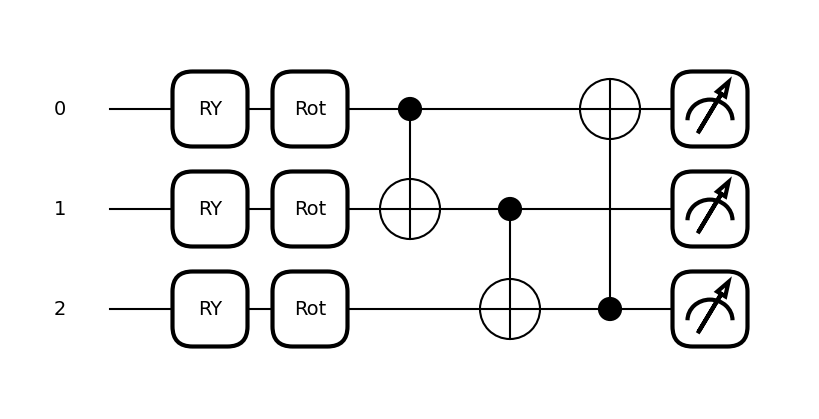

In [ ]:
fig, ax = qml.draw_mpl(qlstm_circuit_explicit)(example_input, example_weights)
plt.show()


**mejores parámetros**

In [ ]:
import itertools
import random
import time
from typing import Dict, Tuple, List

import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
from pennylane import numpy as np

vocabulario = [
    "la", "computación", "cuántica", "procesa", "información",
    "nlp", "texto", "modelo", "entrena", "el", "clásica",
]

corpus = [
    ["la", "computación", "cuántica", "procesa", "información"],
    ["el", "modelo", "entrena", "nlp"],
    ["nlp", "procesa", "el", "texto"],
    ["la", "información", "entrena", "nlp"],
    ["el", "texto", "procesa", "modelo"],
    ["la", "computación", "nlp", "modelo"],
    ["el", "modelo", "procesa", "información"],
    ["la", "información", "texto", "procesa"],
    ["computación", "entrena", "nlp", "modelo"],
    ["el", "texto", "entrena", "información"],
]

vocab_size = len(vocabulario)
word2idx = {w: i for i, w in enumerate(vocabulario)}
idx2word = {i: w for i, w in enumerate(vocabulario)}

def generar_datos(corpus: List[List[str]], tam_contexto: int = 3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            entrada = frase[i : i + tam_contexto]
            salida = frase[i + tam_contexto]
            ejemplos.append((entrada, salida))
    return ejemplos

train_examples = generar_datos(corpus, tam_contexto=3)
random.seed(42)
random.shuffle(train_examples)
val_examples = train_examples[:10]


def phrase_to_tensor(phrase: List[str]):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]


def label_to_tensor(label: str):
    return torch.tensor([word2idx[label]])


class QLSTMCell(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, n_qubits: int, depth: int):
        super().__init__()
        self.n_qubits = n_qubits

        dev = qml.device("default.qubit", wires=n_qubits)

        @qml.qnode(dev, interface="torch")
        def circuit(inputs, weights):
            qml.AngleEmbedding(inputs, wires=range(n_qubits))
            qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (depth, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(circuit, weight_shapes)

        self.fc_in = nn.Linear(input_size + hidden_size, n_qubits)
        self.fc_out = nn.Linear(n_qubits, hidden_size)

    def forward(self, x_t, h_prev):
        combined = torch.cat([x_t, h_prev], dim=-1)
        q_in = self.fc_in(combined)
        q_out = self.q_layer(q_in)
        return torch.tanh(self.fc_out(q_out))


class QLSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, depth, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = QLSTMCell(input_size, hidden_size, n_qubits, depth)
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq):
        h = torch.zeros(self.hidden_size)
        for t in range(input_seq.shape[0]):
            h = self.cell(input_seq[t], h)
        return self.decoder(h)

def train_until_converge(
    model: nn.Module,
    train_data,
    val_data,
    loss_threshold: float = 0.15,
    max_epochs: int = 100,
    lr: float = 0.01,
) -> Tuple[int, float]:

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(1, max_epochs + 1):
        for entrada, etiqueta in train_data:
            x = phrase_to_tensor(entrada)
            y = label_to_tensor(etiqueta)
            pred = model(x)
            loss = criterion(pred.unsqueeze(0), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            total_loss = 0.0
            for entrada, etiqueta in val_data:
                x = phrase_to_tensor(entrada)
                y = label_to_tensor(etiqueta)
                pred = model(x)
                total_loss += criterion(pred.unsqueeze(0), y).item()

        if total_loss < loss_threshold:
            return epoch, total_loss

    return max_epochs, total_loss

def grid_search(
    qubit_options=(3, 4, 5),
    depth_options=(1, 2, 3),
    hidden_size=8,
    loss_threshold=0.15,
):
    results: Dict[str, Dict] = {}
    best: Tuple[str, int] | None = None

    for n_qubits, depth in itertools.product(qubit_options, depth_options):
        tag = f"q={n_qubits},d={depth}"
        print(f"\n>>> Entrenando configuración {tag}")
        model = QLSTM_Generator(
            input_size=vocab_size,
            hidden_size=hidden_size,
            n_qubits=n_qubits,
            depth=depth,
            vocab_size=vocab_size,
        )
        start = time.perf_counter()
        epochs, val_loss = train_until_converge(
            model,
            train_examples,
            val_examples,
            loss_threshold=loss_threshold,
        )
        elapsed = time.perf_counter() - start
        results[tag] = {
            "epochs": epochs,
            "val_loss": round(val_loss, 4),
            "seconds": round(elapsed, 2),
        }

        if best is None or results[tag]["epochs"] < results[best]["epochs"]:
            best = tag

    print("\n===== Resultados ordenados por épocas hasta convergencia =====")
    ordered = sorted(results.items(), key=lambda kv: kv[1]["epochs"])
    for tag, info in ordered:
        e, l, s = info.values()
        print(f"{tag:12s} → {e:3d} épocas, val_loss={l}, tiempo={s}s")

    print("\n>> Mejor configuración:", best, "← convergió en", results[best]["epochs"], "épocas")


if __name__ == "__main__":
    grid_search()


/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(



>>> Entrenando configuración q=3,d=1

>>> Entrenando configuración q=3,d=2

>>> Entrenando configuración q=3,d=3

>>> Entrenando configuración q=4,d=1

>>> Entrenando configuración q=4,d=2

>>> Entrenando configuración q=4,d=3

>>> Entrenando configuración q=5,d=1

>>> Entrenando configuración q=5,d=2

>>> Entrenando configuración q=5,d=3

===== Resultados ordenados por épocas hasta convergencia =====
q=5,d=2      →  73 épocas, val_loss=0.1482, tiempo=113.13s
q=5,d=3      →  81 épocas, val_loss=0.1484, tiempo=169.72s
q=4,d=2      →  96 épocas, val_loss=0.1496, tiempo=121.36s
q=4,d=3      →  99 épocas, val_loss=0.1495, tiempo=161.05s
q=3,d=1      → 100 épocas, val_loss=0.4019, tiempo=74.21s
q=3,d=2      → 100 épocas, val_loss=0.454, tiempo=93.51s
q=3,d=3      → 100 épocas, val_loss=0.186, tiempo=121.52s
q=4,d=1      → 100 épocas, val_loss=0.1847, tiempo=81.8s
q=5,d=1      → 100 épocas, val_loss=0.9655, tiempo=104.27s

>> Mejor configuración: q=5,d=2 ← convergió en 73 épocas



=== LSTM clásico ===
Epoch   0, Loss: 27.1180
Epoch  10, Loss: 11.2741
Epoch  20, Loss: 3.7004
Epoch  30, Loss: 1.3626
Epoch  40, Loss: 0.7208
Epoch  50, Loss: 0.4540
Epoch  60, Loss: 0.3098
Epoch  70, Loss: 0.2191
Epoch  80, Loss: 0.1575
Epoch  90, Loss: 0.1213

Generaciones de ejemplo:
Input: computación entrena nlp             -> Pred: modelo       | Real: modelo
Input: la computación nlp                  -> Pred: modelo       | Real: modelo
Input: la computación cuántica             -> Pred: procesa      | Real: procesa
Input: la información texto                -> Pred: procesa      | Real: procesa
Input: el modelo procesa                   -> Pred: información  | Real: información
Input: computación cuántica procesa        -> Pred: información  | Real: información
Input: el texto procesa                    -> Pred: modelo       | Real: modelo
Input: el texto entrena                    -> Pred: información  | Real: información
Input: el modelo entrena                   -> Pred: n

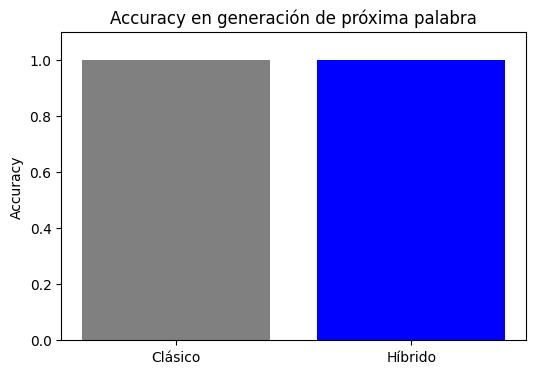

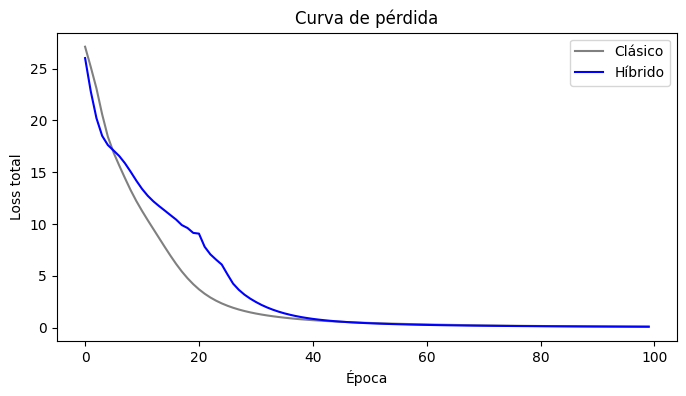

In [ ]:

import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pennylane as qml
import matplotlib.pyplot as plt
from pennylane import draw_mpl


vocabulario = ['la', 'computación', 'cuántica', 'procesa', 'información',
               'nlp', 'texto', 'modelo', 'entrena', 'el', 'clásica']
corpus = [
    ['la', 'computación', 'cuántica', 'procesa', 'información'],
    ['el', 'modelo', 'entrena', 'nlp'],
    ['nlp', 'procesa', 'el', 'texto'],
    ['la', 'información', 'entrena', 'nlp'],
    ['el', 'texto', 'procesa', 'modelo'],
    ['la', 'computación', 'nlp', 'modelo'],
    ['el', 'modelo', 'procesa', 'información'],
    ['la', 'información', 'texto', 'procesa'],
    ['computación', 'entrena', 'nlp', 'modelo'],
    ['el', 'texto', 'entrena', 'información']
]
vocab_size = len(vocabulario)
word2idx = {w: i for i, w in enumerate(vocabulario)}
idx2word = {i: w for i, w in enumerate(vocabulario)}

def generar_datos(corpus, tam_contexto=3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            entrada = frase[i:i+tam_contexto]
            salida = frase[i+tam_contexto]
            ejemplos.append((entrada, salida))
    return ejemplos

train_examples = generar_datos(corpus, tam_contexto=3)
test_examples  = random.sample(train_examples, k=10)

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm    = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                               batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0)
        out, _    = self.lstm(input_seq)
        final_h   = out[0, -1]
        return self.decoder(final_h)

n_qubits = 5
depth    = 2

dev_hybrid = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev_hybrid, interface='torch')
def qlstm_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

class QLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, depth):
        super().__init__()
        weight_shapes  = {"weights": (depth, n_qubits, 3)}
        self.qlayer    = qml.qnn.TorchLayer(qlstm_circuit, weight_shapes)
        self.fc_in     = nn.Linear(input_size + hidden_size, n_qubits)
        self.fc_out    = nn.Linear(n_qubits, hidden_size)
    def forward(self, x_t, h_prev):
        combined = torch.cat([x_t, h_prev], dim=-1)
        q_in     = self.fc_in(combined)
        q_out    = self.qlayer(q_in)
        return torch.tanh(self.fc_out(q_out))

class QLSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, depth, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell   = QLSTMCell(input_size, hidden_size, n_qubits, depth)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_seq):
        h = torch.zeros(self.hidden_size)
        for t in range(input_seq.shape[0]):
            h = self.cell(input_seq[t], h)
        return self.decoder(h)

def entrenar_y_evaluar(model, train_data, test_data, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for frase, label in train_data:
            x = phrase_to_tensor(frase)
            y = label_to_tensor(label)
            pred  = model(x)
            loss  = criterion(pred.unsqueeze(0), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}, Loss: {total_loss:.4f}")

    print("\nGeneraciones de ejemplo:")
    correct = 0
    for frase, label in test_data:
        x = phrase_to_tensor(frase)
        with torch.no_grad():
            logits   = model(x)
            pred_idx = torch.argmax(logits).item()
            pred     = idx2word[pred_idx]
            print(f"Input: {' '.join(frase):35s} -> Pred: {pred:12s} | Real: {label}")
            if pred == label:
                correct += 1
    acc = correct / len(test_data)
    return losses, acc

results = {}

print("\n=== LSTM clásico ===")
lstm = LSTM_Generator(input_size=vocab_size, hidden_size=8, vocab_size=vocab_size)
losses_lstm, acc_lstm = entrenar_y_evaluar(lstm, train_examples, test_examples, epochs=100)
results['Clásico'] = (losses_lstm, acc_lstm)

print("\n=== QLSTM híbrido ===")
qlstm = QLSTM_Generator(
    input_size=vocab_size, hidden_size=8,
    n_qubits=n_qubits, depth=depth,
    vocab_size=vocab_size
)
losses_qlstm, acc_qlstm = entrenar_y_evaluar(qlstm, train_examples,
                                             test_examples, epochs=100)
results['Híbrido'] = (losses_qlstm, acc_qlstm)

plt.figure(figsize=(6, 4))
for modelo, (_, acc) in results.items():
    plt.bar(modelo, acc, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.ylim(0, 1.1)
plt.title("Accuracy en generación de próxima palabra")
plt.ylabel("Accuracy")
plt.show()

plt.figure(figsize=(8, 4))
for modelo, (losses, _) in results.items():
    plt.plot(losses, label=modelo, color={'Clásico': 'gray', 'Híbrido': 'blue'}[modelo])
plt.xlabel("Época")
plt.ylabel("Loss total")
plt.title("Curva de pérdida")
plt.legend()
plt.show()



=== LSTM clásico ===
Epoch   0, Loss: 25.8243
Epoch  10, Loss: 13.6429
Epoch  20, Loss: 6.9720
Epoch  30, Loss: 2.2011
Epoch  40, Loss: 0.9815
Epoch  50, Loss: 0.5856
Epoch  60, Loss: 0.3888
Epoch  70, Loss: 0.2786
Epoch  80, Loss: 0.2131
Epoch  90, Loss: 0.1702

=== QLSTM con 4 puertas ===
Epoch   0, Loss: 25.4394
Epoch  10, Loss: 16.8363
Epoch  20, Loss: 10.8840
Epoch  30, Loss: 3.2366
Epoch  40, Loss: 1.1862
Epoch  50, Loss: 0.5617
Epoch  60, Loss: 0.3377
Epoch  70, Loss: 0.2294
Epoch  80, Loss: 0.1672
Epoch  90, Loss: 0.1286


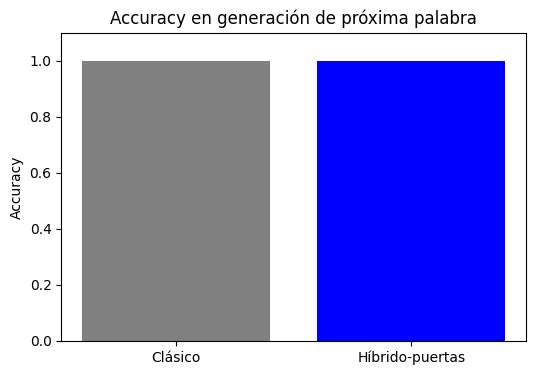

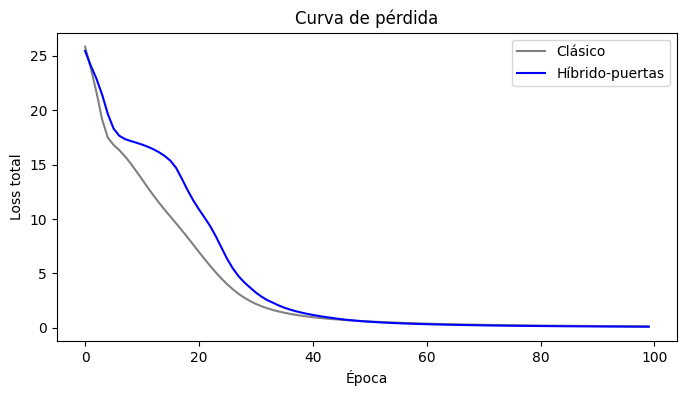

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import matplotlib.pyplot as plt

vocabulario = [
    "la", "computación", "cuántica", "procesa", "información",
    "nlp", "texto", "modelo", "entrena", "el", "clásica",
]
corpus = [
    ["la", "computación", "cuántica", "procesa", "información"],
    ["el", "modelo", "entrena", "nlp"],
    ["nlp", "procesa", "el", "texto"],
    ["la", "información", "entrena", "nlp"],
    ["el", "texto", "procesa", "modelo"],
    ["la", "computación", "nlp", "modelo"],
    ["el", "modelo", "procesa", "información"],
    ["la", "información", "texto", "procesa"],
    ["computación", "entrena", "nlp", "modelo"],
    ["el", "texto", "entrena", "información"],
]

vocab_size = len(vocabulario)
word2idx = {w: i for i, w in enumerate(vocabulario)}
idx2word = {i: w for i, w in enumerate(vocabulario)}

def generar_datos(corpus, tam_contexto=3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            entrada = frase[i : i + tam_contexto]
            salida = frase[i + tam_contexto]
            ejemplos.append((entrada, salida))
    return ejemplos

train_examples = generar_datos(corpus, tam_contexto=3)
random.seed(42)
random.shuffle(train_examples)
val_examples  = train_examples[:10]

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq):
        input_seq = input_seq.unsqueeze(0)
        out, _    = self.lstm(input_seq)
        final_h   = out[0, -1]
        return self.decoder(final_h)

N_QUBITS = 5   # Arquitectura óptima encontrada
DEPTH    = 2

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def gate_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

WEIGHT_SHAPES = {"weights": (DEPTH, N_QUBITS, 3)}

class QuantumGate(nn.Module):

    def __init__(self, input_dim, hidden_size, activation="sigmoid"):
        super().__init__()
        self.pre  = nn.Linear(input_dim, N_QUBITS)
        self.q    = qml.qnn.TorchLayer(gate_circuit, WEIGHT_SHAPES)
        self.post = nn.Linear(N_QUBITS, hidden_size)
        self.act  = torch.sigmoid if activation == "sigmoid" else torch.tanh

    def forward(self, x):
        return self.act(self.post(self.q(self.pre(x))))

class QLSTM_GatedCell(nn.Module):

    def __init__(self, input_size, hidden_size):
        super().__init__()
        cat_dim = input_size + hidden_size
        self.gate_i = QuantumGate(cat_dim, hidden_size, activation="sigmoid")
        self.gate_f = QuantumGate(cat_dim, hidden_size, activation="sigmoid")
        self.gate_o = QuantumGate(cat_dim, hidden_size, activation="sigmoid")
        self.gate_g = QuantumGate(cat_dim, hidden_size, activation="tanh")

    def forward(self, x_t, h_prev, c_prev):
        concat = torch.cat([x_t, h_prev], dim=-1)
        i_t = self.gate_i(concat)
        f_t = self.gate_f(concat)
        o_t = self.gate_o(concat)
        g_t = self.gate_g(concat)
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        return h_t, c_t

class QLSTM_GatedGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell   = QLSTM_GatedCell(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_seq):
        # input_seq: (seq_len, vocab_size)
        h = torch.zeros(self.hidden_size)
        c = torch.zeros(self.hidden_size)
        for t in range(input_seq.shape[0]):
            h, c = self.cell(input_seq[t], h, c)
        return self.decoder(h)

def entrenar_y_evaluar(model, train_data, test_data, epochs=100, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for frase, etiqueta in train_data:
            x = phrase_to_tensor(frase)
            y = label_to_tensor(etiqueta)
            pred = model(x)
            loss = criterion(pred.unsqueeze(0), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}, Loss: {total_loss:.4f}")
    correct = 0
    with torch.no_grad():
        for frase, etiqueta in test_data:
            x = phrase_to_tensor(frase)
            logits = model(x)
            pred   = idx2word[torch.argmax(logits).item()]
            if pred == etiqueta:
                correct += 1
    acc = correct / len(test_data)
    return losses, acc

if __name__ == "__main__":
    train_examples = generar_datos(corpus, tam_contexto=3)
    test_examples  = random.sample(train_examples, k=10)

    resultados = {}

    print("\n=== LSTM clásico ===")
    lstm = LSTM_Generator(input_size=vocab_size, hidden_size=8, vocab_size=vocab_size)
    losses_lstm, acc_lstm = entrenar_y_evaluar(lstm, train_examples, test_examples)
    resultados["Clásico"] = (losses_lstm, acc_lstm)

    print("\n=== QLSTM con 4 puertas ===")
    qlstm = QLSTM_GatedGenerator(input_size=vocab_size, hidden_size=8, vocab_size=vocab_size)
    losses_qlstm, acc_qlstm = entrenar_y_evaluar(qlstm, train_examples, test_examples)
    resultados["Híbrido‑puertas"] = (losses_qlstm, acc_qlstm)

    plt.figure(figsize=(6, 4))
    for modelo, (_, acc) in resultados.items():
        plt.bar(modelo, acc, color={"Clásico": "gray", "Híbrido‑puertas": "blue"}[modelo])
    plt.ylim(0, 1.1)
    plt.title("Accuracy en generación de próxima palabra")
    plt.ylabel("Accuracy")
    plt.show()

    plt.figure(figsize=(8, 4))
    for modelo, (losses, _) in resultados.items():
        plt.plot(losses, label=modelo,
                 color={"Clásico": "gray", "Híbrido‑puertas": "blue"}[modelo])
    plt.xlabel("Época")
    plt.ylabel("Loss total")
    plt.title("Curva de pérdida")
    plt.legend()
    plt.show()



=== LSTM clásico ===
Ep   0 | loss 25.3323
Ep  10 | loss 16.0079
Ep  20 | loss 12.6602
Ep  30 | loss 9.2047
Ep  40 | loss 6.0790
Ep  50 | loss 3.6174
Ep  60 | loss 2.3193
Ep  70 | loss 1.3771
Ep  80 | loss 0.8002
Ep  90 | loss 0.5112
Ep 100 | loss 0.3670
Ep 110 | loss 0.2838
Ep 120 | loss 0.2288
Ep 130 | loss 0.1900
Ep 140 | loss 0.1613

=== QLSTM con mejoras ===
Ep   0 | loss 26.0371
Ep  10 | loss 17.5749
Ep  20 | loss 15.2705
Ep  30 | loss 11.1950
Ep  40 | loss 8.8053
Ep  50 | loss 5.4515
Ep  60 | loss 3.3869
Ep  70 | loss 2.1502
Ep  80 | loss 1.0599
Ep  90 | loss 0.7096
Ep 100 | loss 0.8184
Ep 110 | loss 0.2783
Ep 120 | loss 0.5096
Ep 130 | loss 0.3049
Ep 140 | loss 0.3820


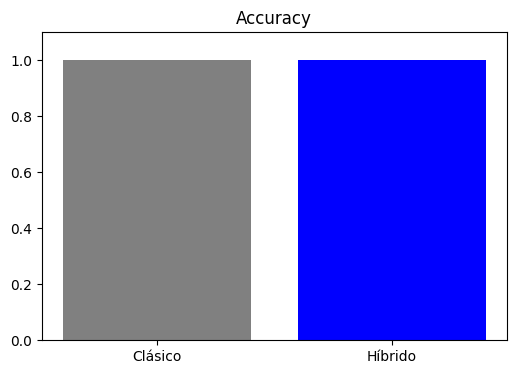

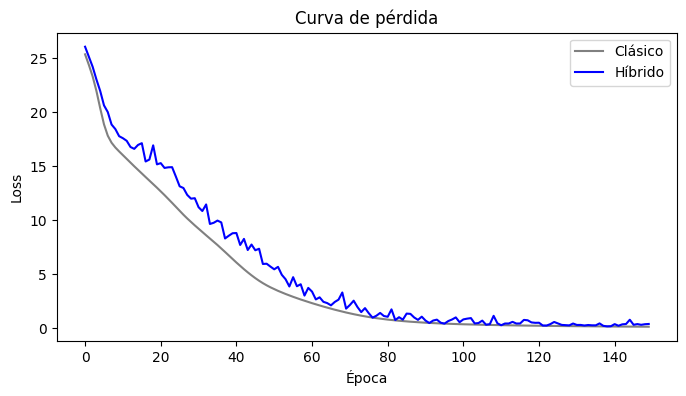

In [ ]:
import random, torch, pennylane as qml, matplotlib.pyplot as plt
from torch import nn, optim

torch.manual_seed(0)
random.seed(0)

vocabulario = [
    "la", "computación", "cuántica", "procesa", "información",
    "nlp", "texto", "modelo", "entrena", "el", "clásica",
]
corpus = [
    ["la", "computación", "cuántica", "procesa", "información"],
    ["el", "modelo", "entrena", "nlp"],
    ["nlp", "procesa", "el", "texto"],
    ["la", "información", "entrena", "nlp"],
    ["el", "texto", "procesa", "modelo"],
    ["la", "computación", "nlp", "modelo"],
    ["el", "modelo", "procesa", "información"],
    ["la", "información", "texto", "procesa"],
    ["computación", "entrena", "nlp", "modelo"],
    ["el", "texto", "entrena", "información"],
]

vocab_size   = len(vocabulario)
word2idx     = {w: i for i, w in enumerate(vocabulario)}
idx2word     = {i: w for i, w in enumerate(vocabulario)}

def generar_datos(corpus, tam_contexto=3):
    ejemplos = []
    for frase in corpus:
        for i in range(len(frase) - tam_contexto):
            ejemplos.append((frase[i : i+tam_contexto], frase[i+tam_contexto]))
    return ejemplos

train_examples = generar_datos(corpus, 3)
random.shuffle(train_examples)
val_examples   = train_examples[:10]

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm    = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(0))
        return self.decoder(out[0, -1])

N_QUBITS   = 5
DEPTH      = 2
REUPLOADS  = 2  # nueva palanca

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def gate_circuit(inputs, weights):
    for r in range(REUPLOADS):
        qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
        qml.StronglyEntanglingLayers(weights[r], wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

WEIGHT_SHAPES = {"weights": (REUPLOADS, DEPTH, N_QUBITS, 3)}

class QuantumGate(nn.Module):
    def __init__(self, in_dim, hidden_size, act="sigmoid"):
        super().__init__()
        self.pre  = nn.Linear(in_dim, N_QUBITS)
        self.q    = qml.qnn.TorchLayer(gate_circuit, WEIGHT_SHAPES)
        self.post = nn.Linear(N_QUBITS, hidden_size)
        self.act  = torch.sigmoid if act == "sigmoid" else torch.tanh
    def forward(self, x):
        return self.act(self.post(self.q(self.pre(x))))

class QLSTM_GatedCell(nn.Module):
    def __init__(self, input_size, hidden):
        super().__init__()
        cat = input_size + hidden
        self.i = QuantumGate(cat, hidden, "sigmoid")
        self.f = QuantumGate(cat, hidden, "sigmoid")
        self.o = QuantumGate(cat, hidden, "sigmoid")
        self.g = QuantumGate(cat, hidden, "tanh")
    def forward(self, x_t, h, c):
        concat = torch.cat([x_t, h], -1)
        i, f, o, g = self.i(concat), self.f(concat), self.o(concat), self.g(concat)
        c = f * c + i * g
        h = o * torch.tanh(c)
        return h, c

class QLSTM_GatedGenerator(nn.Module):
    def __init__(self, input_size, hidden, vocab_size, p_drop=0.1):
        super().__init__()
        self.hidden   = hidden
        self.cell     = QLSTM_GatedCell(input_size, hidden)
        self.dropout  = nn.Dropout(p_drop)
        self.decoder  = nn.Linear(hidden, vocab_size)
    def forward(self, seq):
        h = torch.zeros(self.hidden)
        c = torch.zeros(self.hidden)
        for t in range(seq.shape[0]):
            h, c = self.cell(seq[t], h, c)
        return self.decoder(self.dropout(h))

def entrenar_y_evaluar(model, train, test, epochs=150, lr=0.005):
    opt = optim.AdamW(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    losses, accs = [], []
    for ep in range(epochs):
        total = 0.0
        for frase, lab in train:
            x = phrase_to_tensor(frase)
            y = label_to_tensor(lab)
            pred = model(x)
            loss = crit(pred.unsqueeze(0), y)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # clipping
            opt.step()
            total += loss.item()
        losses.append(total)
        if ep % 10 == 0:
            print(f"Ep {ep:3d} | loss {total:.4f}")
    with torch.no_grad():
        ok = 0
        for frase, lab in test:
            x = phrase_to_tensor(frase)
            pr = idx2word[torch.argmax(model(x)).item()]
            if pr == lab:
                ok += 1
        acc = ok / len(test)
    return losses, acc

if __name__ == "__main__":
    test_examples = random.sample(train_examples, k=10)
    res = {}

    print("\n=== LSTM clásico ===")
    lstm = LSTM_Generator(vocab_size, 8, vocab_size)
    l_loss, l_acc = entrenar_y_evaluar(lstm, train_examples, test_examples)
    res["Clásico"] = (l_loss, l_acc)

    print("\n=== QLSTM con mejoras ===")
    qlstm = QLSTM_GatedGenerator(vocab_size, 8, vocab_size)
    q_loss, q_acc = entrenar_y_evaluar(qlstm, train_examples, test_examples)
    res["Híbrido"] = (q_loss, q_acc)

    plt.figure(figsize=(6,4))
    for m,(_,a) in res.items():
        plt.bar(m, a, color={"Clásico":"gray","Híbrido":"blue"}[m])
    plt.ylim(0,1.1); plt.title("Accuracy"); plt.show()

    plt.figure(figsize=(8,4))
    for m,(ls,_) in res.items():
        plt.plot(ls, label=m, color={"Clásico":"gray","Híbrido":"blue"}[m])
    plt.legend(); plt.title("Curva de pérdida"); plt.xlabel("Época"); plt.ylabel("Loss"); plt.show()


In [ ]:
!pip install --upgrade "fsspec>=2023.12.0" datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.



=== LSTM clásico ===


Época 1/120: 100%|██████████| 100/100 [00:00<00:00, 351.21it/s]


Ep000 loss 230.191


Época 21/120: 100%|██████████| 100/100 [00:00<00:00, 389.73it/s]


Ep020 loss 117.147


Época 41/120: 100%|██████████| 100/100 [00:00<00:00, 372.34it/s]


Ep040 loss 108.563


Época 61/120: 100%|██████████| 100/100 [00:00<00:00, 329.31it/s]


Ep060 loss 99.745


Época 81/120: 100%|██████████| 100/100 [00:00<00:00, 360.53it/s]


Ep080 loss 96.716


Época 101/120: 100%|██████████| 100/100 [00:00<00:00, 371.08it/s]


Ep100 loss 95.696


Época 120/120: 100%|██████████| 100/100 [00:00<00:00, 365.59it/s]



=== QLSTM híbrido ===


Época 1/120: 100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Ep000 loss 230.475


Época 21/120: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Ep020 loss 131.231


Época 41/120: 100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


Ep040 loss 126.260


Época 61/120: 100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


Ep060 loss 120.721


Época 81/120: 100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


Ep080 loss 119.389


Época 101/120: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


Ep100 loss 110.580


Época 120/120: 100%|██████████| 100/100 [00:31<00:00,  3.17it/s]


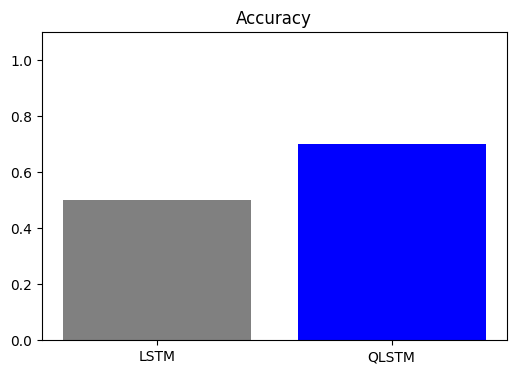

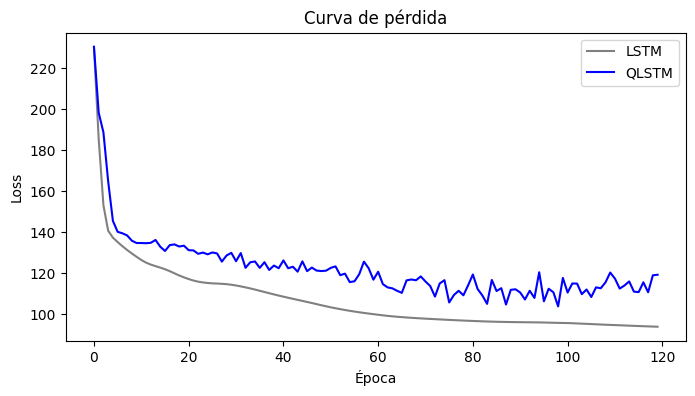

In [ ]:
import random, torch, pennylane as qml, matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

torch.manual_seed(0)
random.seed(0)

det    = ["el", "la"]
noun1  = ["computación", "modelo", "sistema"]
noun2  = ["cuántica", "clásico", "nlp"]
verb   = ["procesa", "entrena", "analiza", "clasifica"]
objeto = ["información", "texto", "datos"]

vocabulario = sorted(set(det + noun1 + noun2 + verb + objeto))

NUM_FRASES = 50
def frase_patrón():
    return [
        random.choice(det),
        random.choice(noun1),
        random.choice(noun2),
        random.choice(verb),
        random.choice(objeto),
    ]
corpus = [frase_patrón() for _ in range(NUM_FRASES)]

vocab_size = len(vocabulario)
word2idx   = {w: i for i, w in enumerate(vocabulario)}
idx2word   = {i: w for w, i in word2idx.items()}

def generar_datos(corpus, ctx=3):
    pares = []
    for frase in corpus:
        for i in range(len(frase) - ctx):
            pares.append((frase[i:i+ctx], frase[i+ctx]))
    return pares

train_examples = generar_datos(corpus, 3)
random.shuffle(train_examples)
val_examples = train_examples[:10]

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dec  = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):
        out,_ = self.lstm(x.unsqueeze(0))
        return self.dec(out[0, -1])

N_QUBITS, DEPTH, REUPS = 5, 2, 2
dev = qml.device("lightning.qubit", wires=N_QUBITS)
@qml.qnode(dev, interface="torch")
def qcirc(inputs, weights):
    for r in range(REUPS):
        qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
        qml.StronglyEntanglingLayers(weights[r], wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]
W_SH = {"weights": (REUPS, DEPTH, N_QUBITS, 3)}

class QGate(nn.Module):
    def __init__(self, dim_in, hidden, act="sigmoid"):
        super().__init__()
        self.pre = nn.Linear(dim_in, N_QUBITS)
        self.q   = qml.qnn.TorchLayer(qcirc, W_SH)
        self.post= nn.Linear(N_QUBITS, hidden)
        self.act = torch.sigmoid if act=="sigmoid" else torch.tanh
    def forward(self, x):
        return self.act(self.post(self.q(self.pre(x))))

class QLSTM_GatedCell(nn.Module):
    def __init__(self, inp, hid):
        super().__init__()
        cat = inp + hid
        self.i = QGate(cat, hid, "sigmoid")
        self.f = QGate(cat, hid, "sigmoid")
        self.o = QGate(cat, hid, "sigmoid")
        self.g = QGate(cat, hid, "tanh")
    def forward(self, x_t, h, c):
        concat = torch.cat([x_t, h], -1)
        i,f,o,g = self.i(concat), self.f(concat), self.o(concat), self.g(concat)
        c = f*c + i*g
        h = o*torch.tanh(c)
        return h,c

class QLSTM_GatedGenerator(nn.Module):
    def __init__(self, inp, hid, vocab, drop=0.1):
        super().__init__()
        self.hid = hid
        self.cell= QLSTM_GatedCell(inp, hid)
        self.drop= nn.Dropout(drop)
        self.dec = nn.Linear(hid, vocab)
    def forward(self, seq):
        h = torch.zeros(self.hid)
        c = torch.zeros(self.hid)
        for t in range(seq.shape[0]):
            h,c = self.cell(seq[t], h, c)
        return self.dec(self.drop(h))

def entrenar_y_eval(model, train, test, epochs=120, lr=0.005):
    opt  = optim.AdamW(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    losses=[]
    for ep in range(epochs):
        tot=0
        for frase,lab in tqdm(train, desc=f"Época {ep+1}/{epochs}"):
            x = phrase_to_tensor(frase)
            y = label_to_tensor(lab)
            out= model(x)
            loss= crit(out.unsqueeze(0), y)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            opt.step(); tot+=loss.item()
        losses.append(tot)
        if ep%20==0: print(f"Ep{ep:03d} loss {tot:.3f}")
    ok=0
    with torch.no_grad():
        for frase,lab in test:
            x=phrase_to_tensor(frase)
            pred=idx2word[torch.argmax(model(x)).item()]
            if pred==lab: ok+=1
    return losses, ok/len(test)

print("\n=== LSTM clásico ===")
lstm = LSTM_Generator(vocab_size, 16, vocab_size)
loss_lstm, acc_lstm = entrenar_y_eval(lstm, train_examples, val_examples)

print("\n=== QLSTM híbrido ===")
qlstm = QLSTM_GatedGenerator(vocab_size, 16, vocab_size)
loss_q, acc_q = entrenar_y_eval(qlstm, train_examples, val_examples)

plt.figure(figsize=(6,4))
plt.bar(["LSTM","QLSTM"], [acc_lstm, acc_q], color=["gray","blue"])
plt.ylim(0,1.1); plt.title("Accuracy"); plt.show()

plt.figure(figsize=(8,4))
plt.plot(loss_lstm, label="LSTM", color="gray")
plt.plot(loss_q, label="QLSTM", color="blue")
plt.legend(); plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de pérdida"); plt.show()


In [ ]:
import random, torch, pennylane as qml, numpy as np
from torch import nn, optim
from tqdm import tqdm

det    = ["el", "la"]
noun1  = ["computación", "modelo", "sistema"]
noun2  = ["cuántica", "clásico", "nlp"]
verb   = ["procesa", "entrena", "analiza", "clasifica"]
objeto = ["información", "texto", "datos"]

vocabulario = sorted(set(det + noun1 + noun2 + verb + objeto))
vocab_size  = len(vocabulario)
word2idx    = {w: i for i, w in enumerate(vocabulario)}
idx2word    = {i: w for w, i in word2idx.items()}

NUM_FRASES = 50
def frase_patrón():
    return [
        random.choice(det),
        random.choice(noun1),
        random.choice(noun2),
        random.choice(verb),
        random.choice(objeto),
    ]
corpus = [frase_patrón() for _ in range(NUM_FRASES)]

def generar_datos(corpus, ctx=3):
    pares = []
    for frase in corpus:
        for i in range(len(frase) - ctx):
            pares.append((frase[i:i+ctx], frase[i+ctx]))
    return pares

all_examples = generar_datos(corpus, 3)
random.shuffle(all_examples)
val_examples   = all_examples[:10]
train_examples = all_examples[10:]

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dec  = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):
        out,_ = self.lstm(x.unsqueeze(0))
        return self.dec(out[0, -1])

N_QUBITS, DEPTH, REUPS = 5, 2, 2
dev = qml.device("lightning.qubit", wires=N_QUBITS)
@qml.qnode(dev, interface="torch")
def qcirc(inputs, weights):
    for r in range(REUPS):
        qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
        qml.StronglyEntanglingLayers(weights[r], wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]
W_SH = {"weights": (REUPS, DEPTH, N_QUBITS, 3)}

class QGate(nn.Module):
    def __init__(self, dim_in, hidden, act="sigmoid"):
        super().__init__()
        self.pre = nn.Linear(dim_in, N_QUBITS)
        self.q   = qml.qnn.TorchLayer(qcirc, W_SH)
        self.post= nn.Linear(N_QUBITS, hidden)
        self.act = torch.sigmoid if act=="sigmoid" else torch.tanh
    def forward(self, x):
        return self.act(self.post(self.q(self.pre(x))))

class QLSTM_GatedCell(nn.Module):
    def __init__(self, inp, hid):
        super().__init__()
        cat = inp + hid
        self.i = QGate(cat, hid, "sigmoid")
        self.f = QGate(cat, hid, "sigmoid")
        self.o = QGate(cat, hid, "sigmoid")
        self.g = QGate(cat, hid, "tanh")
    def forward(self, x_t, h, c):
        concat = torch.cat([x_t, h], -1)
        i,f,o,g = self.i(concat), self.f(concat), self.o(concat), self.g(concat)
        c = f*c + i*g
        h = o*torch.tanh(c)
        return h,c

class QLSTM_GatedGenerator(nn.Module):
    def __init__(self, inp, hid, vocab, drop=0.1):
        super().__init__()
        self.hid = hid
        self.cell= QLSTM_GatedCell(inp, hid)
        self.drop= nn.Dropout(drop)
        self.dec = nn.Linear(hid, vocab)
    def forward(self, seq):
        h = torch.zeros(self.hid)
        c = torch.zeros(self.hid)
        for t in range(seq.shape[0]):
            h,c = self.cell(seq[t], h, c)
        return self.dec(self.drop(h))

def entrenar_y_eval(model, train, test, epochs=120, lr=0.005):
    opt  = optim.AdamW(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    for ep in range(epochs):
        random.shuffle(train)                       #
        for frase,lab in train:
            x = phrase_to_tensor(frase)
            y = label_to_tensor(lab)
            out= model(x)
            loss= crit(out.unsqueeze(0), y)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            opt.step()
    # accuracy en validación
    ok=0
    with torch.no_grad():
        for frase,lab in test:
            x=phrase_to_tensor(frase)
            pred=idx2word[torch.argmax(model(x)).item()]
            if pred==lab: ok+=1
    return ok/len(test)

RUNS = 5
seeds = [42, 1337, 2025, 31415, 777]   # usa las que quieras
acc_lstm_runs, acc_qlstm_runs = [], []

for s in seeds:
    torch.manual_seed(s); random.seed(s); np.random.seed(s)

    lstm   = LSTM_Generator(vocab_size, 16, vocab_size)
    qlstm  = QLSTM_GatedGenerator(vocab_size, 16, vocab_size)

    acc_l = entrenar_y_eval(lstm, train_examples, val_examples)
    acc_q = entrenar_y_eval(qlstm, train_examples, val_examples)

    acc_lstm_runs.append(acc_l)
    acc_qlstm_runs.append(acc_q)
    print(f"Seed {s:<6}  →  LSTM: {acc_l:.2f} | QLSTM: {acc_q:.2f}")

print("\n--- Resumen en 5 repeticiones ---")
print(f"LSTM  mean ± std = {np.mean(acc_lstm_runs):.3f} ± {np.std(acc_lstm_runs):.3f}")
print(f"QLSTM mean ± std = {np.mean(acc_qlstm_runs):.3f} ± {np.std(acc_qlstm_runs):.3f}")


Seed 42      →  LSTM: 0.40 | QLSTM: 0.40
Seed 1337    →  LSTM: 0.40 | QLSTM: 0.40
Seed 2025    →  LSTM: 0.40 | QLSTM: 0.50
Seed 31415   →  LSTM: 0.40 | QLSTM: 0.20
Seed 777     →  LSTM: 0.40 | QLSTM: 0.60

--- Resumen en 5 repeticiones ---
LSTM  mean ± std = 0.400 ± 0.000
QLSTM mean ± std = 0.420 ± 0.133



=== LSTM clásico ===


Época 1/120: 100%|██████████| 200/200 [00:00<00:00, 354.00it/s]


Ep000 loss 456.496


Época 21/120: 100%|██████████| 200/200 [00:00<00:00, 363.37it/s]


Ep020 loss 256.233


Época 41/120: 100%|██████████| 200/200 [00:00<00:00, 357.87it/s]


Ep040 loss 206.472


Época 61/120: 100%|██████████| 200/200 [00:00<00:00, 365.76it/s]


Ep060 loss 188.955


Época 81/120: 100%|██████████| 200/200 [00:00<00:00, 372.98it/s]


Ep080 loss 180.925


Época 101/120: 100%|██████████| 200/200 [00:00<00:00, 359.20it/s]


Ep100 loss 174.727


Época 120/120: 100%|██████████| 200/200 [00:00<00:00, 254.16it/s]



=== QLSTM híbrido ===


Época 1/120: 100%|██████████| 200/200 [01:04<00:00,  3.12it/s]


Ep000 loss 470.096


Época 21/120: 100%|██████████| 200/200 [01:04<00:00,  3.09it/s]


Ep020 loss 276.342


Época 41/120: 100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


Ep040 loss 262.985


Época 61/120: 100%|██████████| 200/200 [01:05<00:00,  3.07it/s]


Ep060 loss 256.186


Época 81/120: 100%|██████████| 200/200 [01:02<00:00,  3.18it/s]


Ep080 loss 255.143


Época 101/120: 100%|██████████| 200/200 [01:02<00:00,  3.20it/s]


Ep100 loss 262.728


Época 120/120: 100%|██████████| 200/200 [01:03<00:00,  3.17it/s]


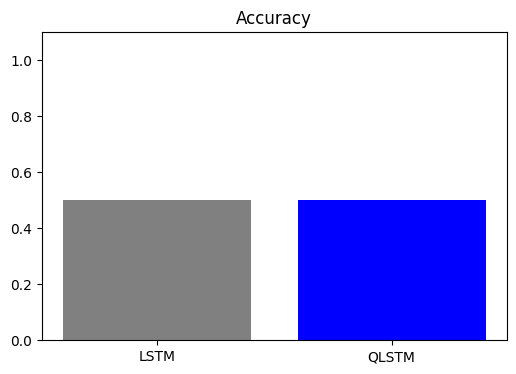

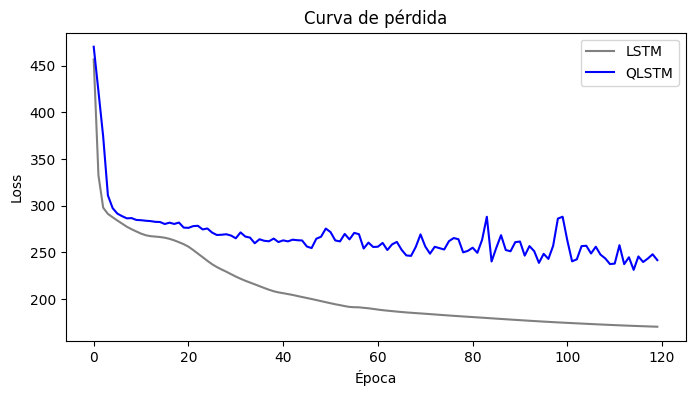

In [ ]:
import random, torch, pennylane as qml, matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm

torch.manual_seed(0)
random.seed(0)

det     = ["el", "la", "un", "una"]
noun1   = ["computación", "modelo", "sistema", "algoritmo"]
noun2   = ["cuántica", "clásico", "nlp", "híbrido"]
verb    = ["procesa", "entrena", "analiza", "clasifica"]
objeto  = ["información", "texto", "datos", "señales"]

vocabulario = sorted(set(det + noun1 + noun2 + verb + objeto))

NUM_FRASES = 100
def frase_patrón():
    return [
        random.choice(det),
        random.choice(noun1),
        random.choice(noun2),
        random.choice(verb),
        random.choice(objeto),
    ]
corpus = [frase_patrón() for _ in range(NUM_FRASES)]

vocab_size = len(vocabulario)
word2idx   = {w: i for i, w in enumerate(vocabulario)}
idx2word   = {i: w for w, i in word2idx.items()}

def generar_datos(corpus, ctx=3):
    pares = []
    for frase in corpus:
        for i in range(len(frase) - ctx):
            pares.append((frase[i:i+ctx], frase[i+ctx]))
    return pares

train_examples = generar_datos(corpus, 3)
random.shuffle(train_examples)
val_examples = train_examples[:10]

def phrase_to_tensor(phrase):
    return torch.eye(vocab_size)[[word2idx[w] for w in phrase]]

def label_to_tensor(label):
    return torch.tensor([word2idx[label]])

class LSTM_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, vocab_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dec  = nn.Linear(hidden_size, vocab_size)
    def forward(self, x):
        out,_ = self.lstm(x.unsqueeze(0))
        return self.dec(out[0, -1])

N_QUBITS, DEPTH, REUPS = 5, 2, 2
dev = qml.device("lightning.qubit", wires=N_QUBITS)
@qml.qnode(dev, interface="torch")
def qcirc(inputs, weights):
    for r in range(REUPS):
        qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
        qml.StronglyEntanglingLayers(weights[r], wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]
W_SH = {"weights": (REUPS, DEPTH, N_QUBITS, 3)}

class QGate(nn.Module):
    def __init__(self, dim_in, hidden, act="sigmoid"):
        super().__init__()
        self.pre = nn.Linear(dim_in, N_QUBITS)
        self.q   = qml.qnn.TorchLayer(qcirc, W_SH)
        self.post= nn.Linear(N_QUBITS, hidden)
        self.act = torch.sigmoid if act=="sigmoid" else torch.tanh
    def forward(self, x):
        return self.act(self.post(self.q(self.pre(x))))

class QLSTM_GatedCell(nn.Module):
    def __init__(self, inp, hid):
        super().__init__()
        cat = inp + hid
        self.i = QGate(cat, hid, "sigmoid")
        self.f = QGate(cat, hid, "sigmoid")
        self.o = QGate(cat, hid, "sigmoid")
        self.g = QGate(cat, hid, "tanh")
    def forward(self, x_t, h, c):
        concat = torch.cat([x_t, h], -1)
        i,f,o,g = self.i(concat), self.f(concat), self.o(concat), self.g(concat)
        c = f*c + i*g
        h = o*torch.tanh(c)
        return h,c

class QLSTM_GatedGenerator(nn.Module):
    def __init__(self, inp, hid, vocab, drop=0.1):
        super().__init__()
        self.hid = hid
        self.cell= QLSTM_GatedCell(inp, hid)
        self.drop= nn.Dropout(drop)
        self.dec = nn.Linear(hid, vocab)
    def forward(self, seq):
        h = torch.zeros(self.hid)
        c = torch.zeros(self.hid)
        for t in range(seq.shape[0]):
            h,c = self.cell(seq[t], h, c)
        return self.dec(self.drop(h))

def entrenar_y_eval(model, train, test, epochs=120, lr=0.005):
    opt  = optim.AdamW(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    losses=[]
    for ep in range(epochs):
        tot=0
        for frase,lab in tqdm(train, desc=f"Época {ep+1}/{epochs}"):
            x = phrase_to_tensor(frase)
            y = label_to_tensor(lab)
            out= model(x)
            loss= crit(out.unsqueeze(0), y)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            opt.step(); tot+=loss.item()
        losses.append(tot)
        if ep%20==0: print(f"Ep{ep:03d} loss {tot:.3f}")
    ok=0
    with torch.no_grad():
        for frase,lab in test:
            x=phrase_to_tensor(frase)
            pred=idx2word[torch.argmax(model(x)).item()]
            if pred==lab: ok+=1
    return losses, ok/len(test)

print("\n=== LSTM clásico ===")
lstm = LSTM_Generator(vocab_size, 16, vocab_size)
loss_lstm, acc_lstm = entrenar_y_eval(lstm, train_examples, val_examples)

print("\n=== QLSTM híbrido ===")
qlstm = QLSTM_GatedGenerator(vocab_size, 16, vocab_size)
loss_q, acc_q = entrenar_y_eval(qlstm, train_examples, val_examples)

plt.figure(figsize=(6,4))
plt.bar(["LSTM","QLSTM"], [acc_lstm, acc_q], color=["gray","blue"])
plt.ylim(0,1.1); plt.title("Accuracy"); plt.show()

plt.figure(figsize=(8,4))
plt.plot(loss_lstm, label="LSTM", color="gray")
plt.plot(loss_q, label="QLSTM", color="blue")
plt.legend(); plt.xlabel("Época"); plt.ylabel("Loss"); plt.title("Curva de pérdida"); plt.show()
